In [1]:
GPS_DATA_DIRECTORY = "data/GPSData"

# Automated load and dump detection with LightGBM

This notebook is intended to demonstrate how the automated load and dump detection algorithm can be used.
Code can be found in load_and_dump_lightgbm.py

The class takes the following initial arguments:
* group_size: The number of data points you want to merge in your GPS Data set
* nb_days: The number of days to analyze
* work_dir: The relative path where you want to store output

In [2]:
from load_dump_lightgbm import LoadDumpLightGBM
myModel = LoadDumpLightGBM(nb_days=1, gps_data_dir=GPS_DATA_DIRECTORY) #More days will lead to larger training data, probably leading to a better model

Initializing class:
----------------------
Data over:  1 days.
Merging  5  consecutive timestamps
All data saved to  data/ml_model_data/class_data


Load GPSData and convert to a functional structure for the model by using the load_data method. This should take some time, increasing for a higher number of days.

In [3]:
myModel.load_data()

Start at day  03-07-2022
For machine type:  Truck


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:44<00:00, 44.95s/it]


Fit the model to the data set. The fit method will return the learning curve of the training process, providing the logloss of both the training and validation data set. The training process is determined based on a early stopping criteria. If validation error does not increase over a period of n_iterations (2 in this case), training is terminated. 

Additionally, the importance of each feature in the data set is provided. The higher the value on the x-axis, the higher importance. The x-value signals the number of times each feature is used to split a node in the decision trees, consequently the feature utilized for the maximal information gain.

In [4]:
myModel.fit()

myModel.plot_learning_curve()
myModel.plot_feature_importances()

Training until validation scores don't improve for 2 rounds
Early stopping, best iteration is:
[132]	Train's multi_logloss: 0.000529723	Val's multi_logloss: 0.0317205


The predict method..

In [5]:
myModel.predict()

<Figure size 1000x1000 with 0 Axes>

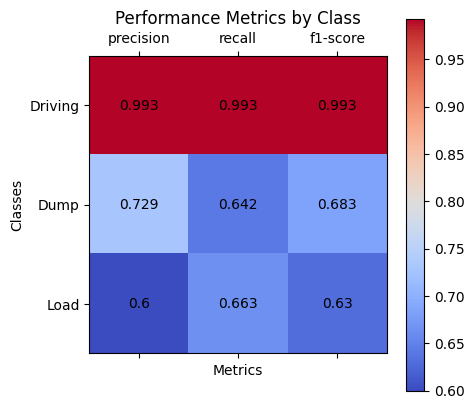

In [6]:
myModel.metrics_2d_plot()

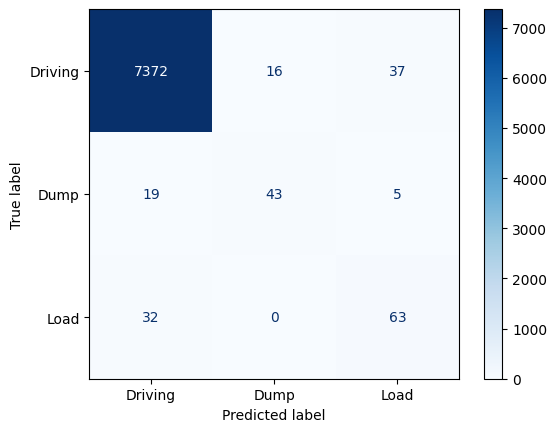

In [7]:
myModel.confusion_matrix()

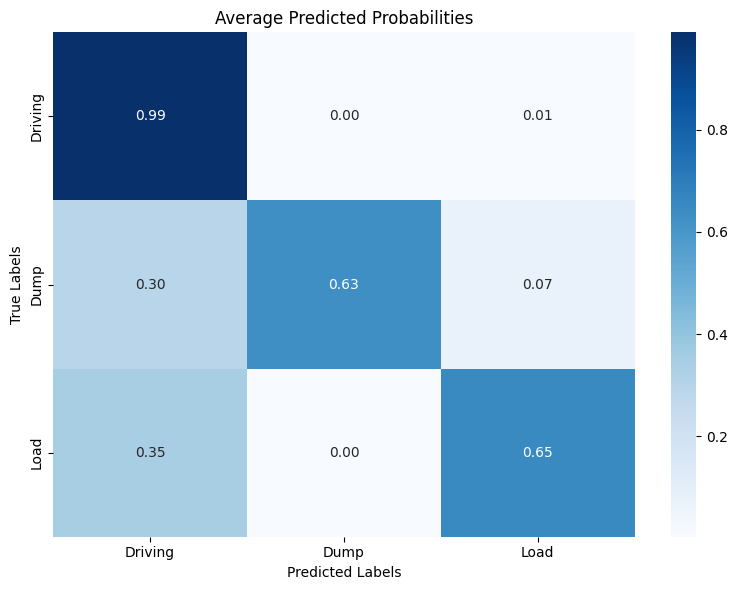

In [8]:
myModel.confusion_matrix_with_probabilities()